<a href="https://colab.research.google.com/github/tengfeixia/RN_avec_des_incertitudes_propag-es/blob/main/DNN_version2_2_adam%2Bincer_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split


print ("TF Version", tf.__version__)

TF Version 2.5.0


(10000, 1)
[[-0.37032278]
 [ 0.30485871]
 [-0.66217801]
 ...
 [ 0.210989  ]
 [ 0.30609514]
 [-0.03133827]]


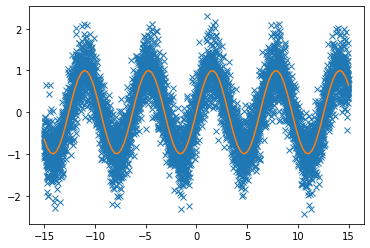

In [2]:
# generate data

X= 3*np.arange(-5,5,0.001)

X = np.atleast_2d(X)
X = X.T



print (np.shape(X))
Y= np.sin(X)

sigmay = 0.5*Y*np.random.randn (10000,1)+0.01

print (sigmay)



X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.2,shuffle = True) 

y_train += sigmay[0:8000,:]
y_test += sigmay[8000:10000,:]

plt.plot (X_train,y_train, "x", markersize = 6) #gerenrate data by fonction y = sin (6x) avec des incertitudes aléatories sur x


x = np.linspace(-15,15,100) #print the cruve sin (6x)
y =np.sin(x)
plt.plot (x,y)


In [12]:
class Layer:

    def __init__ (self,n_input,n_neurons, activation = None, weights = None, bias = None):

        """
        int n_input: nb de noeuds entrées (nb de noeuds de la couche précédente)
        int n_neurons: nb de noeuds sorties (nb de noeuds de la couche actuelle)
        str activation: type de la fonction d'activation 
        weights, bias: généré dans les couches
        """

        self.weights = weights if weights is not None else 10*np.random.randn(n_input,n_neurons)*np.sqrt(2/(n_neurons+n_input))
        print ("weights", self.weights)
        self.incer_weights = None 
        
        self.bias = bias if bias is not None else np.zeros((n_neurons))
        print ("bias", self.bias)
                        
        self.nb_neurons = n_neurons 

        self.activation = activation
        self.activation_value = None
        self.error = None
        self.delta = None
        self.gradient = None
        self.x = None
        self.z = None

        #pour adam
        #bias
        self.v_b = 0
        self.grad_sq_b = 0
        self.v_hat_b = 0
        self.grad_sq_hat_b = 0

        #weights
        self.v_w = 0
        self.grad_sq_w = 0
        self.v_hat_w = 0
        self.grad_sq_hat_w = 0
        self.grad = None 

        #incertitude
        self.sigmay = None 


        # feed forward propagation

    def feedforward (self,x):
        self.x = x
        z = np.dot (x,self.weights) + self.bias # z = wx+b
        self.z =z
        self.activation_value = self.apply_activation (z)
        
        return self.activation_value

        # fonction d'activaiton

    def feedforward_incertitude (self, sigmay):
        self.incer_weights = np.square (self.weights)
        sigmay = np.square (sigmay)
        sigmay = np.dot (sigmay, self.incer_weights)
        sigmay = self.apply_activation_derivation (self.activation_value)*sigmay
        sigmay = np.sqrt(sigmay)
        

        return sigmay
        


    def apply_activation(self, z):

        if self.activation is None:
            return z
        elif self.activation == "relu":
            return np.maximum(z, 0)
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
    

        # dérivés des fonctions d'activation,， attention le input c'est a, value activé
    def apply_activation_derivation(self, a):

        if self.activation is None:
            return np.ones_like(a)
        elif self.activation == "relu":
            grad = np.array(a, copy=True)
            grad[a > 0] = 1.
            grad[a<= 0] = 0.
            return grad
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "sigmoid":
            return a* (1 - a)


weights [[ 4.57141171  5.41962302 -7.52592526 -4.63823638]]
bias [0. 0. 0. 0.]
weights [[ 0.10229492  1.71894034  6.43014137 -2.60370491]
 [-6.33208406  3.16225621  1.34076526  5.18840422]
 [12.66449013  8.10162672  7.40696002  4.92027552]
 [-2.94510915 -0.95100253  0.51164013  0.19514429]]
bias [0. 0. 0. 0.]
weights [[-9.88221591  2.18454494]
 [-5.23435679  4.94957073]
 [-5.31307071 -5.51817513]
 [ 3.35112072  2.80794693]]
bias [0. 0.]
weights [[-1.25296015]
 [-6.67281875]]
bias [0.]
MSE: 65752.28435615863 0
MSE: 764.8945401538715 100
MSE: 630.6034006572077 200
MSE: 559.7798488380865 300
MSE: 657.7814567929552 400
MSE: 530.4111346711409 500
MSE: 514.9511584253876 600
MSE: 512.7346491838554 700
MSE: 511.0436440585316 800
MSE: 509.15127377097735 900
MSE: 505.8659186449669 1000
MSE: 500.00114415673363 1100
MSE: 495.8157048195854 1200
MSE: 496.17997723125507 1300
MSE: 497.34222753245496 1400
MSE: 495.11255662684755 1500
MSE: 493.30113253943864 1600
MSE: 494.3726925135873 1700
MSE: 497.893

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


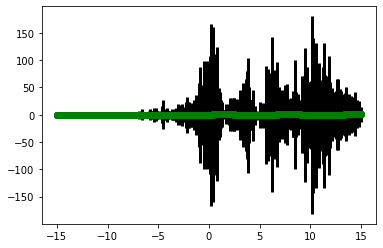

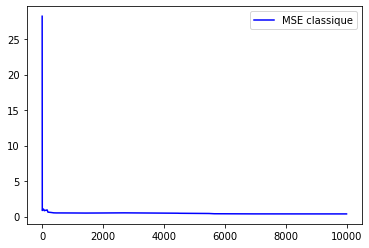

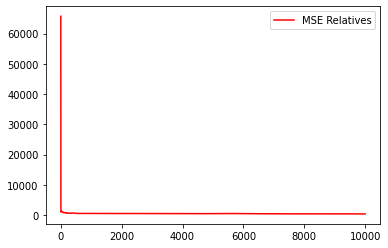

In [13]:
# Neural Network

class NN:
    def __init__ (self):
        self.__layers = []
        
        #paramètres adam
        self.gamma = 0.9
        self.beta = 0.99
        self.epsilon = 10**-8
        

    def add_layer (self, layer): #add layer
        self.__layers.append(layer)

    def feed_forward (self, X): # X --> my_nn.feed_forward (X) --> y_predict
        for layer in self.__layers:
            X = layer.feedforward (X)
        return X

    def feed_forward_incertitude (self, sigma):
        for layer in self.__layers:
            sigma = layer.feedforward_incertitude(sigma)
        return sigma

    def back_propagation (self, X_train, y_train,sigmay,facteur_incer, lr):
        y_predict = self.feed_forward(X_train)

        layer_incertitude = self.feed_forward_incertitude (sigmay)
        #print ("predict",y_predict)
        #print ("incertitude", layer_incertitude)

        for i in reversed(range(len(self.__layers))):
            current_layer = self.__layers[i] #get layer            
    
            if current_layer == self.__layers [-1]:  # si current == couche output
                current_layer.error = (y_predict - y_train)/(facteur_incer*layer_incertitude)
                #print ("layer error",current_layer.error)
                #print ("layer incertitude", layer_incertitude)
                for element in layer_incertitude:
                    if element < 1e-10:
                        element = 1e-10
                current_layer.delta = 2*current_layer.error * current_layer.apply_activation_derivation (y_predict)
                
                previous_layer = self.__layers [i-1]
                
                #print ("delta_output", current_layer.delta)

                #adam pour bias            
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                #print ("test1",current_layer.bias)
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )

                #print ("test2",current_layer.bias)
                
                
                #adam pour weights
                
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value)).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))
                

            
            else:
                next_layer = self.__layers[i+1] #les incertitudes dépendent de la couche prochaine
                
                current_layer.error = np.dot(next_layer.weights, next_layer.delta)

                #print ("layer erroe",current_layer.error)
                #print ("fprime",current_layer.apply_activation_derivation(current_layer.activation_value))
                current_layer.delta = current_layer.error* current_layer.apply_activation_derivation(current_layer.activation_value)
                #print ("delta",current_layer.delta)
                #print ("delta_layers", current_layer.delta)

                # ________________________________adam pour bias
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                #print ("test3",current_layer.bias)
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )
                #print ("test4",current_layer.bias)

                #__________________________________adam pour weights

                
                previous_layer = self.__layers [i-1]
    
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value if current_layer != self.__layers [0] else X_train )).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))



    def train (self,X_train,X_test,y_train,y_test,sigmay,facteur_incer, lr, epochs):
        mses = []
        mses_relatives=[]
        
        monitor =0
        for i in range (epochs):
            for j in range (len (X_train)):

                self.back_propagation(X_train[j],y_train[j],sigmay[j],facteur_incer,lr)

            mse_test = np.mean(np.square(self.feed_forward(X_test)- y_test))
            mses.append (mse_test)
            

            if i % 1 ==0:
                    
                mse_relative = np.mean(np.square((self.feed_forward(X_train)- y_train)/(sigmay[0:8000,:]*10)))
                if i%100 ==0:
                    print ("MSE:", mse_relative,i)
                mses_relatives.append(mse_relative)

                #plt.figure()
                #plt.suptitle(i)
                #plt.plot (X_test,self.feed_forward(X_test), "x", markersize = 6)

        fig, ax = plt.subplots()
        x = np.linspace(-15,15,100) #print the cruve sin (6x)
        y =np.sin(x)
        plt.plot (x,y)
        ax.errorbar (X_test,self.feed_forward(X_test),yerr = self.feed_forward_incertitude(sigmay[8000:,:]), fmt = "o", color = "green", ecolor = "black",elinewidth = 3)

        return mses, mses_relatives



    


my_nn = NN()
my_nn.add_layer(Layer(1, 4, "sigmoid")) 
my_nn.add_layer(Layer(4, 4, "sigmoid"))  
my_nn.add_layer(Layer(4, 2, "sigmoid"))
my_nn.add_layer(Layer(2, 1, None))  



#X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.25,shuffle = False) #!!!!!!!!

#mses = my_nn.train(X_train[0:1,:] ,X_test,y_train[0:1,:],y_test,sigmay [0:1,:],0.005,1)
mses, mses_relatives = my_nn.train(X_train,X_test,y_train,y_test,sigmay ,100,1e-4,10000)

plt.figure()
plt.plot(mses, 'b', label='MSE classique')
plt.legend()
plt.figure()
plt.plot (mses_relatives,'r', label = 'MSE Relatives')
plt.legend()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
/usr/local/l

<Figure size 7200x7200 with 0 Axes>

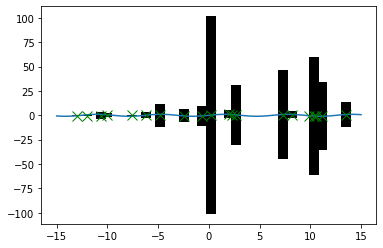

<Figure size 7200x7200 with 0 Axes>

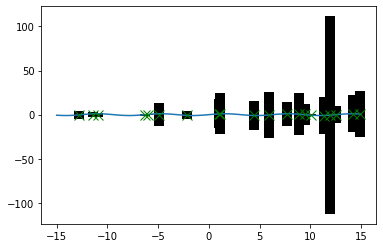

<Figure size 7200x7200 with 0 Axes>

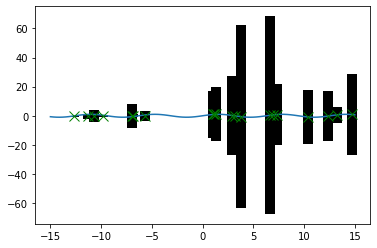

<Figure size 7200x7200 with 0 Axes>

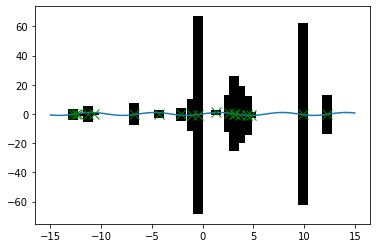

<Figure size 7200x7200 with 0 Axes>

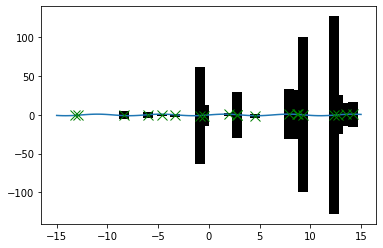

In [14]:
for i in range (5):
    plt.figure(figsize = (100,100))
    fig, ax = plt.subplots()
    x = np.linspace(-15,15,100) 
    y =np.sin(x)
    plt.plot (x,y)

    ax.errorbar (X_test[i*20:(i+1)*20,:],my_nn.feed_forward(X_test[i*20:(i+1)*20,:]),yerr = my_nn.feed_forward_incertitude(sigmay[7500+i*20:7500+(i+1)*20,:]), fmt = "x", markersize = 10,color = "green", ecolor = "black",elinewidth = 10)

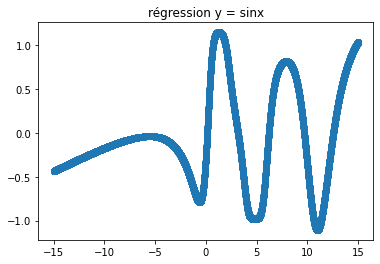

In [16]:
plt.figure()
plt.title ("régression y = sinx")
plt.scatter (X, my_nn.feed_forward(X))